##### <h1 style="color:Green;">Week 4 Lecture Source Code</h1> 

<a style="color:purple;" href="https://docs.google.com/presentation/d/1_jQKSrS4hiVJaxnFYhRh284AhAbPxI0CL0qAP4Iz-DE/edit#slide=id.p">[Week 4 Lecture Link Here]</a>

<h2 style="color:Green;">Setup and Loading Packages</h2> Setup and Loading Packages

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, plot_confusion_matrix, f1_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_multilabel_classification

import pandas_datareader as pdr

What is Classification?

Classification is a supervised learning concept that uses one or more predictors (features, independent variables) to categorize a set of data into classes. This concept can be applied to solve two-class or multi-class calssification problems, in real-world scenarios such as:

• Identifying economic cycles (e.g., expansion, peak, through, recession)

• Classifying credit card transactions as legitimate or fraudulent

• Classifying market strend structures as uptrend, congestion, downtrend

• Categorizing news stories of finance as having positive, neutral, or negative sentiments

• Recognizing handwritten checks and digits as one of {A, B, C, …, Z, 0, 1, ... 9}

• Assigning trading attributes to their origin of cause (e.g., Greece, UK, Russia)


Note that different assumptiosn are made for each classification model.

<h2 style="color:Green;">Simulated Data (pg. 3)</h2>

<b> Example of a Binary Classification Problem </b>

Let's use the data we processed from last lecture. This contains sector ETFs, XLK (Technology) and IYC (Consumer Discretionary), as well as SPY (S&P 500) directions from 1/25/2018 to 5/31/2022, a total of 1086 trading days.

In [62]:
DATA1 = pd.read_csv('SPY_XLK_IYC.csv')
DATA1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1086 non-null   object 
 1   SPY     1086 non-null   float64
 2   XLK     1086 non-null   float64
 3   IYC     1086 non-null   float64
dtypes: float64(3), object(1)
memory usage: 34.1+ KB


In [64]:
# converting SPY log returns into binary values 1's and 0's
DATA1['SPY Direction'] = (DATA1.SPY > 0).astype(int)

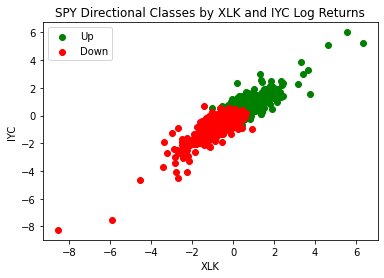

In [70]:
plt.scatter(DATA1.XLK[DATA1['SPY Direction'] == 1],
            DATA1.IYC[DATA1['SPY Direction'] == 1],
           color='green',
           label='Up')
plt.scatter(DATA1.XLK[DATA1['SPY Direction'] == 0],
            DATA1.IYC[DATA1['SPY Direction'] == 0],
           color='red',
           label='Down')
plt.title('SPY Directional Classes by XLK and IYC Log Returns')
plt.xlabel('XLK')
plt.ylabel('IYC')
plt.legend()
plt.show()

From the scatter plot, besides a fairly strong linear relationship, we can see that the data points are divided into red and green colors, green representing an upward direction in SPY and red represeneting a downward direction in SPY. One of the most popular problems in quantitative finance is to find a classifier (model) that most-accurately separates the data points that indicates an upward move from those that indicate a downward move. Through this model, we will be able to predict under any given conditions of XLK and IYC log returns, which direction would SPY be expected to move in the next trading day. 

<b> Example of a Multi-class Classification Problem </b>

Note that here, we split the data by their quantiles just so each of the 4 classes can dominate roughly 25% of the data set, hence making the data set less biased and eliminating the label imbalance issue.

In [88]:
# categorizing SPY returns into 2 directional classes
multiInterval = [DATA1.SPY.min(), DATA1.SPY.quantile(.25), 0, DATA1.SPY.quantile(.75), DATA1.SPY.max()]
multiLabels   = ['major loss','minor loss','minor gain','major gain']
DATA1['SPY Return Type'] = pd.cut(DATA1.SPY, bins = multiInterval, labels=multiLabels)

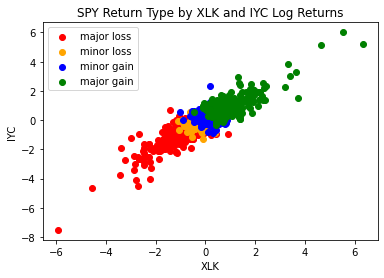

In [78]:
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'major loss'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'major loss'],
           color='red',
           label='major loss')
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'minor loss'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'minor loss'],
           color='orange',
           label='minor loss')
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'minor gain'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'minor gain'],
           color='blue',
           label='minor gain')
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'major gain'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'major gain'],
           color='green',
           label='major gain')

plt.title('SPY Return Type by XLK and IYC Log Returns')
plt.xlabel('XLK')
plt.ylabel('IYC')
plt.legend()
plt.show()

This is a multi-class classification problem, one that consists of > 2 SPY return type classes. Be aware that we are no longer evaluating the asset's directional, but rather the magnitude of its daily gains/losses. Our goall is fond the classifier (model) of multiple lines that most-accurately separate the SPY return type into their corresponding classes.

<h2 style="color:Green;">EDA on Trading Factors Data (pg. 18)</h2>

Here, we examine the trading signals of the top 500 most-traded stock in the U.S. from 1/21/2013 to 9/30/2017. This data set was originally used to indicate market behaviors in the U.S. during the European struggles such as the Greece's debt crisis in 2015 and Brexit in 2017. One of the behaviors is the fluctuation of market participants, and a way to measure this is through trading volumes, in other words, the transactions of assets throughout a period in time. In our case, we will be looking at monthly volumes, specifically how they are classified to imply low, medium, or high liquidity. 


Our goal is to use the trading factors to help train the classification models to predict market liquidity. The utilization of this is to inform the concentration of the selected market a trader is trading in. We start by loading the data set and categorizing volumes into 3 respective liquidity classes.

In [2]:
DATA2 = pd.read_csv('trading_factors_data.csv')
DATA2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31435 entries, 0 to 31434
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sector     31435 non-null  object 
 1   atr        31435 non-null  float64
 2   macd       31435 non-null  float64
 3   rsi        31435 non-null  float64
 4   bb_mid     31435 non-null  float64
 5   bb_upper   31435 non-null  float64
 6   bb_lower   31435 non-null  float64
 7   liquidity  31435 non-null  object 
dtypes: float64(6), object(2)
memory usage: 1.9+ MB


Standardizing numerical indictors in the data set.

In [3]:
LABEL = 'liquidity'
FEATURES = DATA2.columns
FEATURES = [f for f in FEATURES if f not in ['liquidity','sector']]

In [4]:
DATA2.loc[:, FEATURES] = scale(DATA2.loc[:, FEATURES]) # standardizing indicators

Create dummy variables to covert sector categories into numerical ones.

In [5]:
# get the dummies and store it in a variable
dummies = pd.get_dummies(DATA2.sector)

# Concatenate the dummies to original dataframe
merged = pd.concat([DATA2, dummies], axis='columns')
    
# drop the values
DATA2 = merged.drop(['sector'], axis='columns')

# See data info
DATA2.head()

,atr,macd,rsi,bb_mid,bb_upper,bb_lower,liquidity,Basic Industries,Capital Goods,Consumer Durables,Consumer Non-Durables,Consumer Services,Energy,Finance,Health Care,Miscellaneous,Public Utilities,Technology,Transportation
0,-1.392712,1.079815,1.008666,-0.695295,-0.716651,-0.672630,Medium,0,1,0,0,0,0,0,0,0,0,0,0
1,-0.084627,0.348207,-0.197922,-0.409229,-0.417685,-0.399921,Medium,0,0,0,0,0,0,0,0,0,0,0,1
2,-1.592250,0.071391,-0.252138,0.390414,0.363185,0.416133,Low,0,0,0,0,1,0,0,0,0,0,0,0
3,0.009927,-1.841691,-1.416073,0.230941,0.324129,0.139020,High,0,0,0,0,0,0,0,0,0,0,1,0
4,-1.302958,0.229371,0.685063,-0.307687,-0.329960,-0.285088,Medium,0,0,0,0,0,0,0,1,0,0,0,0


As an example, we have ploted the stocks' liquidity class by the indicators macd vs bb_mid.

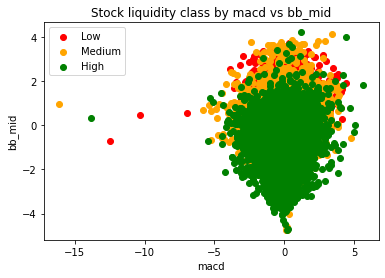

In [6]:
plt.scatter(DATA2['macd'][DATA2.liquidity == 'Low'],
            DATA2['bb_mid'][DATA2.liquidity == 'Low'],
           color='red',
           label='Low')
plt.scatter(DATA2['macd'][DATA2.liquidity == 'Medium'],
            DATA2['bb_mid'][DATA2.liquidity == 'Medium'],
           color='orange',
           label='Medium')
plt.scatter(DATA2['macd'][DATA2.liquidity == 'High'],
            DATA2['bb_mid'][DATA2.liquidity == 'High'],
           color='green',
           label='High')

plt.title('Stock liquidity class by macd vs bb_mid')
plt.xlabel('macd')
plt.ylabel('bb_mid')
plt.legend()
plt.show()

Encoding liquidity strengths into numerical numbers. <br>
The Medium liquidity is encoded as 2, Low as 1, and high as 0.<br>

In [7]:
le = LabelEncoder()
le.fit(DATA2.loc[:, LABEL])
DATA2.liquidity = le.fit_transform(DATA2.loc[:, LABEL])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'High': 0, 'Low': 1, 'Medium': 2}

Splitting data into 80% training set and 20% testing set.

In [27]:
FEATURES = FEATURES+dummies.columns.to_list()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(DATA2.loc[:, FEATURES], DATA2.loc[:, LABEL], test_size=0.2, random_state=0)

<b>Feature Importance</b>

In [29]:
from sklearn.ensemble import RandomForestClassifier # importing the random forest module

rf_model = RandomForestClassifier(random_state=0) # define the random forest model

rf_model.fit(X_train, y_train) # fit the random forest model

importances = rf_model.feature_importances_ # get importance

indices = np.argsort(importances) # sort the features' index by their importance scores

Ranking features by thier relative importance scores.

Text(0.5, 0, 'Relative Importance')

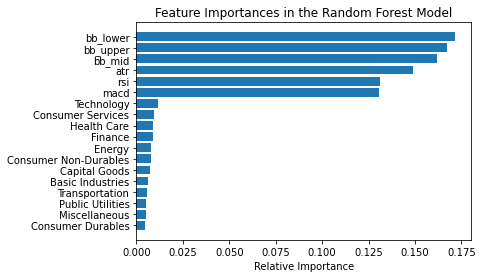

In [11]:
plt.title('Feature Importances in the Random Forest Model')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [FEATURES[i] for i in indices])
plt.xlabel('Relative Importance')

Let's keep the features with importance scores of at least 0.05. These will be bb_lower, bb_upper, bb_mid, atr, rsi, and macd . Then, we drop the remaining features with less significant scores. You can say, let's not include the sector dummies at the very beginning, but we wouldn't know their importances until we see their scores here.

In [30]:
FEATURES_TO_DROP=[FEATURES[i] for i in indices[importances[indices] < 0.05]]

In [31]:
DATA2 = DATA2.drop(columns=FEATURES_TO_DROP) # drop feature in the original data set
X_train = X_train.drop(columns = FEATURES_TO_DROP) # drop feature in the training data set
X_test = X_test.drop(columns= FEATURES_TO_DROP) # drop feature in the testing data set
FEATURES = [f for f in FEATURES if f not in FEATURES_TO_DROP] 

<b>Multicollinearity</b>

We use VIF to test for multicollinearity since the remaining features are numerical; if the features are categorical, we would use Chi-square test to test for correlation. At first we found bb_mid, bb_upper, and bb_lower have inf values, which iindicates an R squared of 1 and a perfect correlation. 

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF = [variance_inflation_factor(DATA2.loc[:, FEATURES].values, i) for i in range(len(FEATURES))]
VIF_table = pd.DataFrame({'Features': FEATURES, 'VIF': VIF})
VIF_table

C:\Users\user\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF
0,atr,1.18631
1,macd,2.69763
2,rsi,2.69259
3,bb_mid,inf
4,bb_upper,inf
5,bb_lower,inf


To resolve this problem, let's keep just the bb_mid feature and discard bb_upper and bb_lower. The result shows low VIF values for this set of features because they are all < 5. Since they are not considered to have high correlations, we will keep them as our final predictors for the liquidity strength.

In [33]:
FEATURES = [f for f in FEATURES if f not in ['bb_upper', 'bb_lower']]

In [34]:
VIF = [variance_inflation_factor(DATA2.loc[:, FEATURES].values, i) for i in range(len(FEATURES))]
VIF_table = pd.DataFrame({'Features': FEATURES, 'VIF': VIF})
VIF_table

,Features,VIF
0,atr,1.095002
1,macd,2.686477
2,rsi,2.688805
3,bb_mid,1.076711


<b>Label Imbalance</b>

Let's investigate whether there is a label imbalance issue. We count the number of observations with High, Medium, and Low liquidity, then plotted them using a barplot. The minority-to-majority ratio of SPY directions matches about a 2:1:1 ratio or 50% samples in the Medium class and 25% samples in the High and Low classes. 

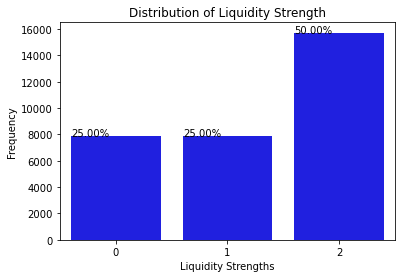

In [23]:
ax = sns.countplot(x = "liquidity", data = DATA2, color = 'blue')
plt.title('Distribution of Liquidity Strength')
plt.xlabel('Liquidity Strengths')
plt.ylabel('Frequency')
total = len(DATA2["liquidity"])
for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x_coord = p.get_x() 
        y_coord = p.get_y() + p.get_height()+0.02
        ax.annotate(percentage, (x_coord, y_coord))

Althought liquidity strengths are not perfectly balanced, in reality, it is reasonable to allow the bias of medium liquidity in the market since the high and low levels only occur 2 to 3 hours of the 8 hours trading per day.

<b>Dropping correlated columns in training and testing data</b>

In [35]:
X_train, X_test = X_train.loc[:, FEATURES], X_test.loc[:, FEATURES]

<h2 style="color:Green;">Fitting Classification Models (pg. 33)</h2>

<b>K-Nearest Neighbors (KNN) - pg. 33</b>

How do we select the number of neighbors? We would use the a K-Fold Cross Validation (CV) approach as opposed to the validation set approach because it generates more stable MSE's.<br><br>
Say that we want to test the performance of the 1-Nearest Neighbor, then 2-Nearest Neighbor, ..., 10-Nearest Neighbor models. We will iterate through each model to compute it's Mean Squared Error (MSE) through a 5-Fold CV. Of course you can use other fold's of CV as well. However, please note that if you use 1-Fold CV (aka Leave-One-Out CV) or some lower number of folds for a large data set, it will take a longer time for the algorithm to run because the data set has to be splitted into more groups.

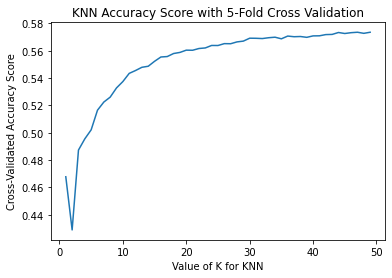

In [32]:
from sklearn.neighbors import KNeighborsClassifier
# Specifying the K in K-Fold CV
k_cv = 5
# choose k between 1 to 30
k_range = range(1, 50)
k_accuracy = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy = cross_val_score(knn, DATA2.loc[:, FEATURES], DATA2.loc[:, LABEL], cv=k_cv, scoring='accuracy')
    k_accuracy.append(accuracy.mean())
    
plt.plot(k_range, k_accuracy)
plt.title('KNN Accuracy Score with '+str(k_cv)+'-Fold Cross Validation')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy Score')
plt.show()

The accuracy score rises sharply from when K=1 to K=10, then seems to grow slowly, from when K=10 to K=30, then grows even more slowly after K=30. Therefore, we would choose K=30 as the number of nearest neighbor for our KNN model. Let's go ahead to fit the model with this parameter setting!

In [43]:
# # build KNN model and choose n_neighbors
knn = KNeighborsClassifier(n_neighbors=30)
# train the model
knn.fit(X_train, y_train)
# predicted liquidity strengths 
knn_pred_train = knn.predict(X_train)
knn_pred_test = knn.predict(X_test)

Calculating training and testing errors.

In [44]:
knn_train_error= np.mean(knn_pred_train!=y_train)
knn_test_error= np.mean(knn_pred_test != y_test)
print('KNN Training Error = %.3f' % knn_train_error)
print('KNN Testing Error = %.3f' % knn_test_error)

KNN Training Error = 0.398
KNN Testing Error = 0.429


Calculating training and testing accuracy scores.

In [45]:
knn_train_accuracy= knn.score(X_train,y_train)
knn_test_accuracy= knn.score(X_test,y_test)
print('KNN Training Accuracy Score = %.3f' % knn_train_accuracy)
print('KNN Testing Accuracy Score = %.3f' % knn_test_accuracy)

KNN Training Accuracy Score = 0.602
KNN Testing Accuracy Score = 0.571


Visualizing a confusion matrix. 


Text(0.5, 1.0, 'KNN Confusion Matrix')

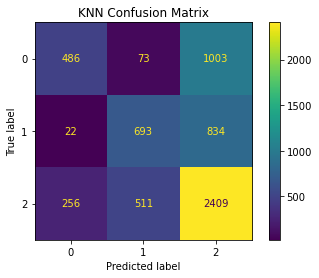

In [46]:
plot_confusion_matrix(knn, X_test, y_test)
plt.title("KNN Confusion Matrix")

Summarizing Precision, Recall, F1 Score, and Support.

In [47]:
# storing f1 score
knn_f1_score= f1_score(y_test, knn_pred_test, average='weighted')
# printing full report
print(classification_report(y_test, knn_pred_test))

              precision    recall  f1-score   support

           0       0.64      0.31      0.42      1562
           1       0.54      0.45      0.49      1549
           2       0.57      0.76      0.65      3176

    accuracy                           0.57      6287
   macro avg       0.58      0.51      0.52      6287
weighted avg       0.58      0.57      0.55      6287



Calculating AUC score.

In [48]:
knn_pred_test_proba = knn.predict_proba(X_test)
knn_auc_score = roc_auc_score(y_test, knn_pred_test_proba, multi_class='ovr')
print('KNN Classifier: ROC AUC=%.3f' % knn_auc_score)

KNN Classifier: ROC AUC=0.721


<b>Support Vector Machines (SVM) - pg. 42</b>

In [49]:
from sklearn import svm
# build SVC model and choose the Radial Basis Function (RBF) kernel function
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, probability=True).fit(X_train, y_train)
# choose the Polynomial kernel function
poly = svm.SVC(kernel='poly', degree=3, C=1, probability=True).fit(X_train, y_train)

# predicted liquidity strengths 
rbf_pred_train = rbf.predict(X_train)
rbf_pred_test = rbf.predict(X_test)
poly_pred_train = poly.predict(X_train)
poly_pred_test = poly.predict(X_test)

Calculating training and testing errors.

In [50]:
rbf_train_error= np.mean(rbf_pred_train!=y_train)
rbf_test_error= np.mean(rbf_pred_test != y_test)
print('SVC (RBF Kernel) Training Error = %.3f' % rbf_train_error)
print('SVC (RBF Kernel) Testing Error = %.3f' % rbf_test_error)
poly_train_error= np.mean(poly_pred_train!=y_train)
poly_test_error= np.mean(poly_pred_test != y_test)
print('SVC (3rd-Degree Polynomial Kernel) Training Error = %.3f' % poly_train_error)
print('SVC (3rd-Degree Polynomial Kernel) Testing Error = %.3f' % poly_test_error)

SVC (RBF Kernel) Training Error = 0.417
SVC (RBF Kernel) Testing Error = 0.414
SVC (3rd-Degree Polynomial Kernel) Training Error = 0.451
SVC (3rd-Degree Polynomial Kernel) Testing Error = 0.448


Calculating training and testing accuracy scores.

In [51]:
rbf_train_accuracy= rbf.score(X_train,y_train)
rbf_test_accuracy= rbf.score(X_test,y_test)
print('SVC (RBF Kernel) Training Accuracy Score = %.3f' % rbf_train_accuracy)
print('SVC (RBF Kernel) Testing Accuracy Score = %.3f' % rbf_test_accuracy)
poly_train_accuracy= poly.score(X_train,y_train)
poly_test_accuracy= poly.score(X_test,y_test)
print('SVC (3rd-Degree Polynomial Kernel) Training Accuracy Score = %.3f' % poly_train_accuracy)
print('SVC (3rd-Degree Polynomial Kernel) Testing Accuracy Score = %.3f' % poly_test_accuracy)

SVC (RBF Kernel) Training Accuracy Score = 0.583
SVC (RBF Kernel) Testing Accuracy Score = 0.586
SVC (3rd-Degree Polynomial Kernel) Training Accuracy Score = 0.549
SVC (3rd-Degree Polynomial Kernel) Testing Accuracy Score = 0.552


Visualizing SVC-RBF confusion matrix. 

Text(0.5, 1.0, 'SVC (RBF Kernel) Confusion Matrix')

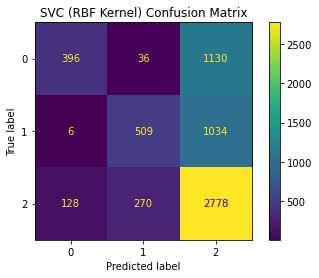

In [52]:
plot_confusion_matrix(rbf, X_test, y_test)
plt.title("SVC (RBF Kernel) Confusion Matrix")

Visualizing SVC-Polynomial confusion matrix. 

Text(0.5, 1.0, 'SVC (3rd-Degree Polynomial Kernel) Confusion Matrix')

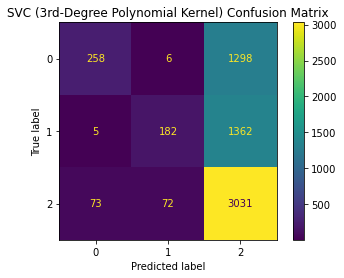

In [53]:
plot_confusion_matrix(poly, X_test, y_test)
plt.title("SVC (3rd-Degree Polynomial Kernel) Confusion Matrix")

Summarizing Precision, Recall, F1 Score, and Support.

In [54]:
# storing f1 score
rbf_f1_score= f1_score(y_test, rbf_pred_test, average='weighted')
print(classification_report(y_test, rbf_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.25      0.38      1562
           1       0.62      0.33      0.43      1549
           2       0.56      0.87      0.68      3176

    accuracy                           0.59      6287
   macro avg       0.64      0.49      0.50      6287
weighted avg       0.62      0.59      0.55      6287



In [55]:
# storing f1 score
poly_f1_score= f1_score(y_test, poly_pred_test, average='weighted')
print(classification_report(y_test, poly_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.17      0.27      1562
           1       0.70      0.12      0.20      1549
           2       0.53      0.95      0.68      3176

    accuracy                           0.55      6287
   macro avg       0.67      0.41      0.39      6287
weighted avg       0.63      0.55      0.46      6287



Calculating AUC score.

In [56]:
rbf_pred_test_proba = rbf.predict_proba(X_test)
rbf_auc_score = roc_auc_score(y_test, rbf_pred_test_proba, multi_class='ovr')
poly_pred_test_proba = poly.predict_proba(X_test)
poly_auc_score = roc_auc_score(y_test, poly_pred_test_proba, multi_class='ovr')
print('SVC (RBF Kernel) Classifier: ROC AUC=%.3f' % rbf_auc_score)
print('SVC (3rd-Degree Polynomial Kernel) Classifier: ROC AUC=%.3f' % poly_auc_score )

SVC (RBF Kernel) Classifier: ROC AUC=0.739
SVC (3rd-Degree Polynomial Kernel) Classifier: ROC AUC=0.719


<b>Decision (Classification) Tree - pg. 55</b>

We limit our decision tree to include the first 25 observations in the training data because, as seen in the next code chunk output, including all observations will generate a huge tree, which makes it difficult to visualize and interpret.

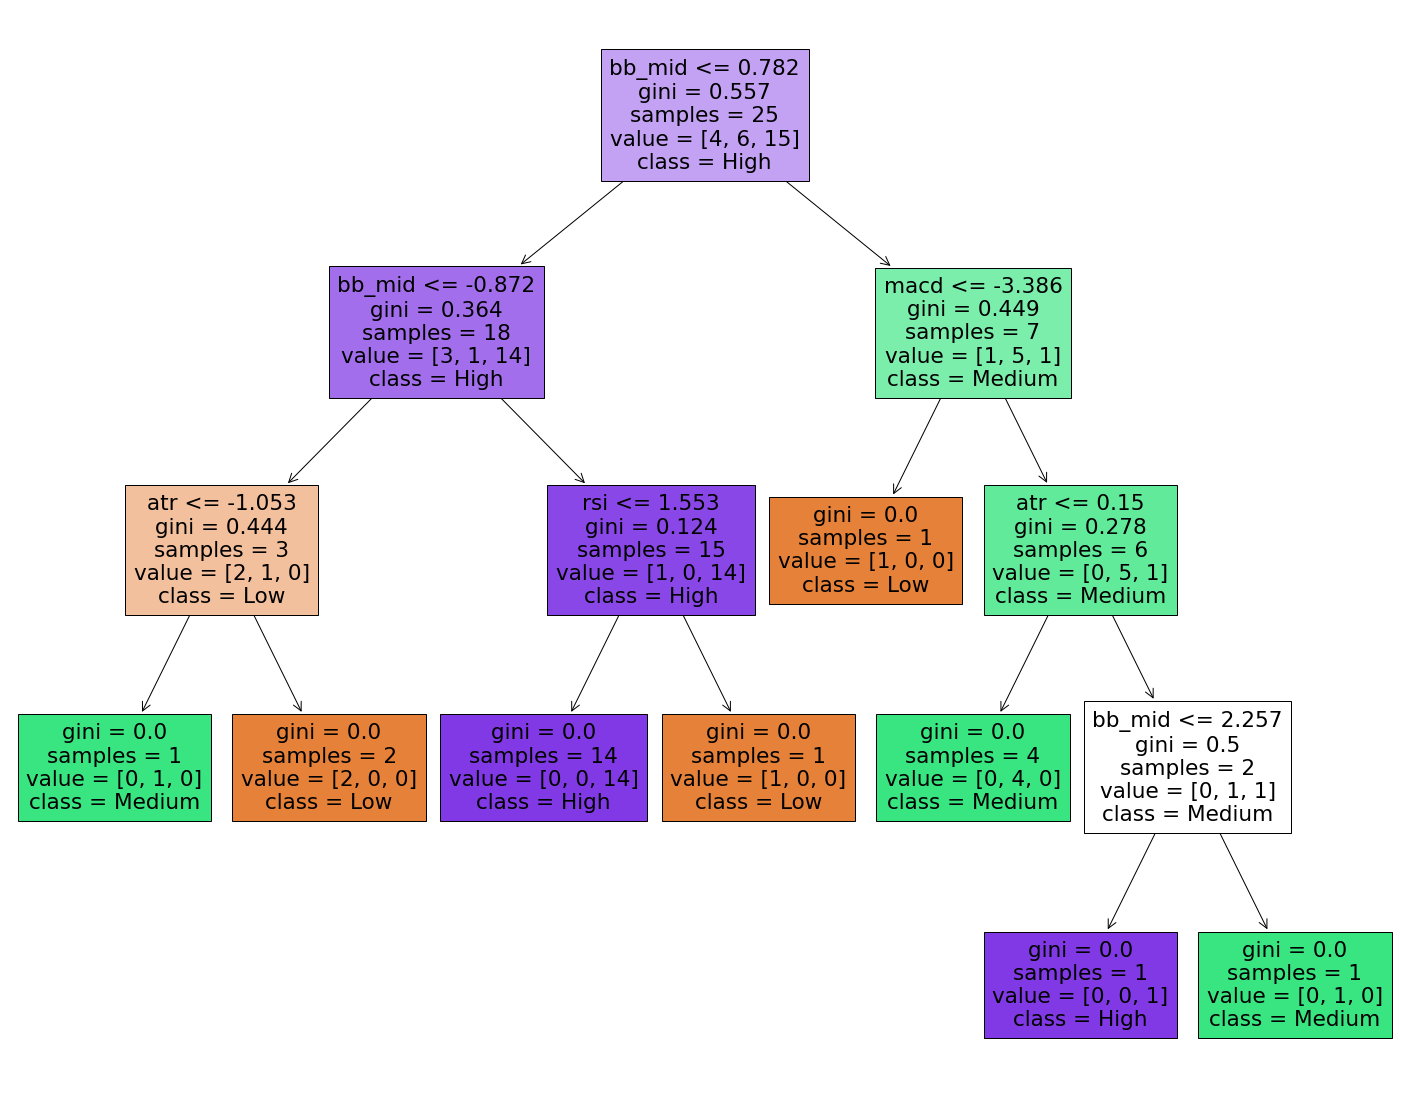

In [57]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
# Fit the classifier with default hyper-parameters
dt = DecisionTreeClassifier(random_state=0).fit(X_train.head(25),y_train[:25])
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, feature_names=FEATURES, class_names=['Low','Medium','High'], filled=True)

This is the tree output when we include all training data. As you can see, there are many many more questions being asked at each node beforemoving on to the next node. This code chunk takes approximately 15 minutes to run, that's why I commented this part out to spare you from costly computing :)

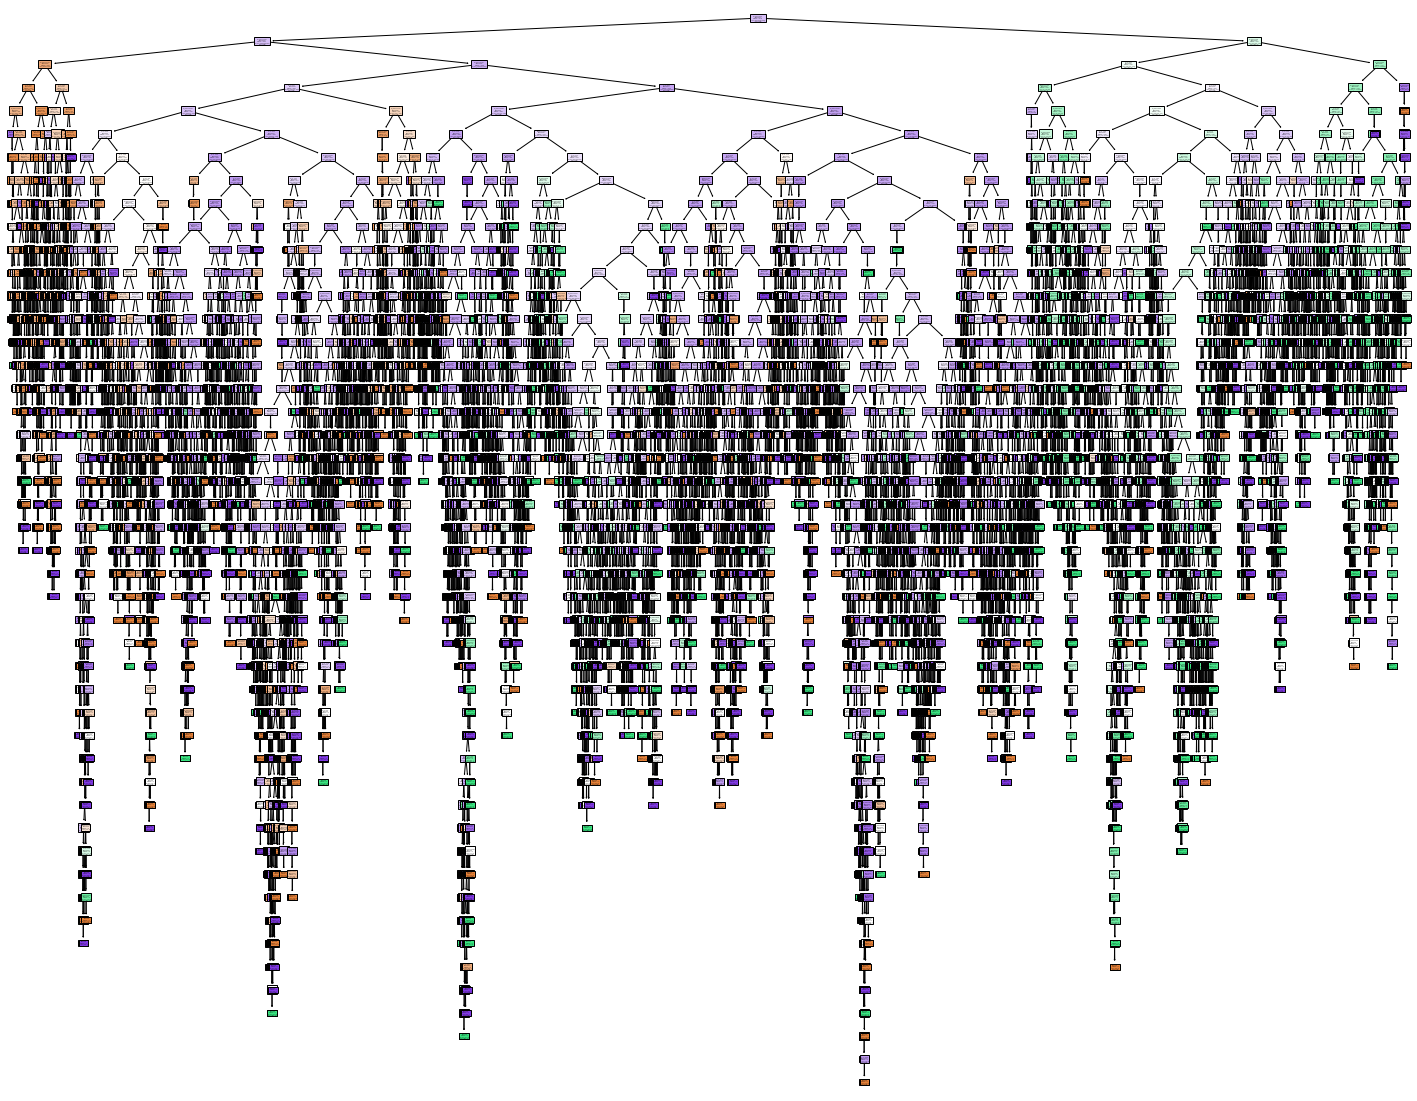

In [107]:
# # Fit the classifier with default hyper-parameters
# dt = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dt, feature_names=FEATURES, class_names=['Low','Medium','High'], filled=True)

In [33]:
def visualize_classifier(model, X_train, y_train, ax=None, cmap='rainbow'):
    X = np.array(X_train.head(25)); y = np.array(y_train[:25])
    
    ax = plt.gca()
    
    # Plot the training points
    ax.scatter(X[:,0], X[:,1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X[:,:2], y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    ax.set_title("Tree Boundaries")

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'clim'


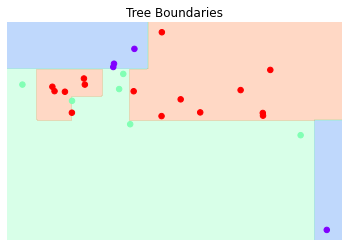

In [34]:
visualize_classifier(DecisionTreeClassifier(), X_train, y_train)

We will shose to use "gini" impurity as the decision tree's criterion. Gini impurity measures the divergences between the probability distributions of the target attribute’s values and splits a node such that it gives the least amount of impurity. <br>

We chose the "best" splitter to evaluate all splits using the criterion before splitting. This will calculate the best features to split based on the impurity measure and use that to split the nodes. <br>

We then use GridSearchCV to seek for the best-estimated tree depth. If your tree is too deep, your model will become more complex because you will have more splits and it may lead to overfitting in decision trees because your model will fit perfectly for the training data and will not be able to generalize well on test set. If your tree is too shallow, it may lead to underfitting for the opposite reasons.

In [38]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(3,20)}
dt = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
dt.fit(X_train, y_train)
tree_model = dt.best_estimator_
print (dt.best_score_, dt.best_params_) 

0.5752743352966314 {'max_depth': 6}


In [58]:
# fitting decision tree model
dt = DecisionTreeClassifier(criterion = "gini", splitter = "best", max_depth = 6)
dt.fit(X_train, y_train)

# predicted liquidity strengths 
dt_pred_train = dt.predict(X_train)
dt_pred_test = dt.predict(X_test)

Calculating training and testing errors.

In [59]:
dt_train_error= np.mean(dt_pred_train!=y_train)
dt_test_error= np.mean(dt_pred_test != y_test)
print('Decision Tree Training Error = %.3f' % dt_train_error)
print('Decision Tree Testing Error = %.3f' % dt_test_error)

Decision Tree Training Error = 0.413
Decision Tree Testing Error = 0.425


Calculating training and testing accuracy scores.

In [60]:
dt_train_accuracy= dt.score(X_train,y_train)
dt_test_accuracy= dt.score(X_test,y_test)
print('Decision Tree Training Accuracy Score = %.3f' % dt_train_accuracy)
print('Decision Tree Testing Accuracy Score = %.3f' % dt_test_accuracy)

Decision Tree Training Accuracy Score = 0.587
Decision Tree Testing Accuracy Score = 0.575


Visualizing decision tree confusion matrix.

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

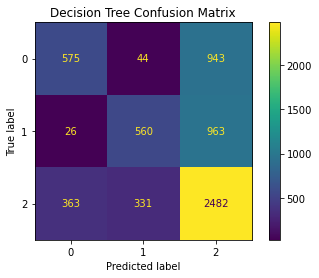

In [61]:
plot_confusion_matrix(dt, X_test, y_test)
plt.title("Decision Tree Confusion Matrix")

Summarizing Precision, Recall, F1 Score, and Support.

In [62]:
# storing f1 score
dt_f1_score= f1_score(y_test, dt_pred_test, average='weighted')
print(classification_report(y_test, dt_pred_test))

              precision    recall  f1-score   support

           0       0.60      0.37      0.46      1562
           1       0.60      0.36      0.45      1549
           2       0.57      0.78      0.66      3176

    accuracy                           0.58      6287
   macro avg       0.59      0.50      0.52      6287
weighted avg       0.58      0.58      0.56      6287



Calculating AUC score.

In [63]:
dt_pred_test_proba = dt.predict_proba(X_test)
dt_auc_score = roc_auc_score(y_test, dt_pred_test_proba, multi_class='ovr')
print('Decision Tree Classifier: ROC AUC=%.3f' % dt_auc_score)

Decision Tree Classifier: ROC AUC=0.723


<b>Ensemble Method: Bagging - pg. 69</b><br><br>
I have used GridSearchCV to tune the optimal parameter values.

In [71]:
# Create the parameter grid based on the results of random search 
from sklearn.ensemble import BaggingClassifier
param_grid = {
    'n_estimators': [10, 25, 50, 100, 200, 300, 1000],
    'max_samples':[1, 5, 10],
    'max_features': [1, 2 , 3 , 4]
}
# Create a based model
bagging = BaggingClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = bagging, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# fit the grid search to the training data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 84 candidates, totalling 252 fits


{'max_features': 4, 'max_samples': 10, 'n_estimators': 1000}

In [66]:
# Creating a Bagging classifier
bagging = BaggingClassifier(max_features= 4, max_samples= 10, n_estimators= 1000)
# fit the bagging on the training data
bagging.fit(X_train, y_train)

# predicted liquidity strengths 
bagging_pred_train = bagging.predict(X_train)
bagging_pred_test = bagging.predict(X_test)

Calculating training and testing errors.

In [67]:
bagging_train_error= np.mean(bagging_pred_train!=y_train)
bagging_test_error= np.mean(bagging_pred_test != y_test)
print('Bagging Training Error = %.3f' % bagging_train_error)
print('Bagging Testing Error = %.3f' % bagging_test_error)

Bagging Training Error = 0.462
Bagging Testing Error = 0.460


Calculating training and testing accuracy scores.

In [68]:
bagging_train_accuracy= bagging.score(X_train,y_train)
bagging_test_accuracy= bagging.score(X_test,y_test)
print('Bagging Training Accuracy Score = %.3f' % bagging_train_accuracy)
print('Bagging Testing Accuracy Score = %.3f' % bagging_test_accuracy)

Bagging Training Accuracy Score = 0.538
Bagging Testing Accuracy Score = 0.540


Visualizing bagging confusion matrix.

Text(0.5, 1.0, 'Bagging Confusion Matrix')

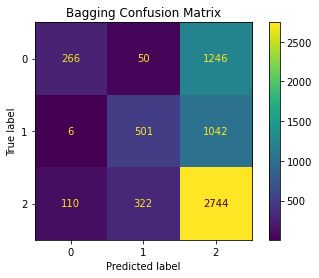

In [131]:
plot_confusion_matrix(bagging, X_test, y_test)
plt.title("Bagging Confusion Matrix")

Summarizing Precision, Recall, F1 Score, and Support.

In [69]:
# storing f1 score
bagging_f1_score= f1_score(y_test, bagging_pred_test, average='weighted')
print(classification_report(y_test, bagging_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.05      0.09      1562
           1       0.58      0.29      0.39      1549
           2       0.53      0.90      0.67      3176

    accuracy                           0.54      6287
   macro avg       0.63      0.42      0.38      6287
weighted avg       0.61      0.54      0.46      6287



Calculating AUC score.

In [70]:
bagging_pred_test_proba = bagging.predict_proba(X_test)
bagging_auc_score = roc_auc_score(y_test, bagging_pred_test_proba, multi_class='ovr')
print('Bagging Classifier: ROC AUC=%.3f' % bagging_auc_score)

Bagging Classifier: ROC AUC=0.718


<b>Ensemble Method: Random Forest - pg. 74</b>

Again, I have used GridSearchCV to tune the optimal parameter values. Since it takes over an hour to cross-validate candidate values for each parameter, I have commented out the code chunk and specified the model parameters for you below to spare your time from the time-consuming CV task.<br><br>

n_estimators: This defines the number of decision trees we would like to have in the random forest. The GridSearchCV seclected 200.

min_samples_split: The minimum number of sample required to split a node which is internal. The GridSearchCV seclected 8.

max_depth:The maximum depth of the tree. The GridSearchCV seclected 110.

max_features: Maximum number of features for best split. The GridSearchCV seclected 2.

In [57]:
# # Create the parameter grid based on the results of random search 
# # Import Random Forest Model
# from sklearn.ensemble import RandomForestClassifier
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# # fit the grid search to the training data
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 200}

In [36]:
#Create a Random Forest Classifier
rf = RandomForestClassifier(bootstrap= True, max_depth= 110, max_features= 2, min_samples_leaf= 5, min_samples_split= 8, n_estimators= 200)
#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

# predicted liquidity strengths 
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)

Calculating training and testing errors.

In [37]:
rf_train_error= np.mean(rf_pred_train!=y_train)
rf_test_error= np.mean(rf_pred_test != y_test)
print('Random Forest Training Error = %.3f' % rf_train_error)
print('Random Forest Testing Error = %.3f' % rf_test_error)

Random Forest Training Error = 0.181
Random Forest Testing Error = 0.427


Calculating training and testing accuracy scores.

In [38]:
rf_train_accuracy= rf.score(X_train,y_train)
rf_test_accuracy= rf.score(X_test,y_test)
print('Random Forest Training Accuracy Score = %.3f' % rf_train_accuracy)
print('Random Forest Testing Accuracy Score = %.3f' % rf_test_accuracy)

Random Forest Training Accuracy Score = 0.819
Random Forest Testing Accuracy Score = 0.573


Visualizing bagging confusion matrix.

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

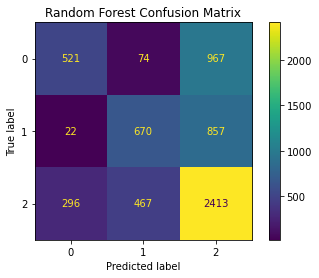

In [39]:
plot_confusion_matrix(rf, X_test, y_test)
plt.title("Random Forest Confusion Matrix")

Summarizing Precision, Recall, F1 Score, and Support.

In [40]:
# storing f1 score
rf_f1_score= f1_score(y_test, rf_pred_test, average='weighted')
print(classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       0.62      0.33      0.43      1562
           1       0.55      0.43      0.49      1549
           2       0.57      0.76      0.65      3176

    accuracy                           0.57      6287
   macro avg       0.58      0.51      0.52      6287
weighted avg       0.58      0.57      0.56      6287



Calculating AUC score.

In [41]:
rf_pred_test_proba = rf.predict_proba(X_test)
rf_auc_score = roc_auc_score(y_test, rf_pred_test_proba, multi_class='ovr')
print('Random Forest Classifier: ROC AUC=%.3f' % rf_auc_score)

Random Forest Classifier: ROC AUC=0.725


<b>Ensemble Method: Boosting (AdaBoost) - pg. 80</b>

There are different types of boosting algorithms: AdaBoost, Gradient Boosting and XG Boost . We will use the AdaBoost algorithm for this course. Again, we used GridSearchCV to tune the n_estimators (=200) and learning_rate (=1) of this boosting model.

In [69]:
from sklearn.ensemble import AdaBoostClassifier
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [50, 100, 200, 300, 1000],
    'learning_rate':[1, 5, 10]
}
# Create a based model
boosting = AdaBoostClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = boosting, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# fit the grid search to the training data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


{'learning_rate': 1, 'n_estimators': 200}

In [73]:
#Create a Boosting Classifier
boosting = AdaBoostClassifier(learning_rate= 1, n_estimators= 200)
#Train the model using the training sets y_pred=clf.predict(X_test)
boosting.fit(X_train,y_train)

# predicted liquidity strengths 
boosting_pred_train = boosting.predict(X_train)
boosting_pred_test = boosting.predict(X_test)

Calculating training and testing errors.

In [74]:
boosting_train_error= np.mean(boosting_pred_train!=y_train)
boosting_test_error= np.mean(boosting_pred_test != y_test)
print('AdaBoost Training Error = %.3f' % boosting_train_error)
print('AdaBoost Testing Error = %.3f' % boosting_test_error)

AdaBoost Training Error = 0.415
AdaBoost Testing Error = 0.415


Calculating training and testing accuracy scores.

In [75]:
boosting_train_accuracy= boosting.score(X_train,y_train)
boosting_test_accuracy= boosting.score(X_test,y_test)
print('AdaBoost Training Accuracy Score = %.3f' % boosting_train_accuracy)
print('AdaBoost Testing Accuracy Score = %.3f' % boosting_test_accuracy)

AdaBoost Training Accuracy Score = 0.585
AdaBoost Testing Accuracy Score = 0.585


Visualizing bagging confusion matrix.

Text(0.5, 1.0, 'AdaBoost Confusion Matrix')

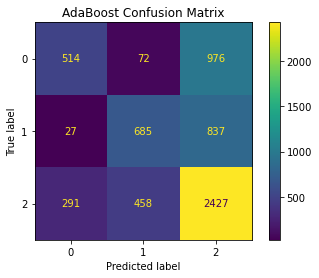

In [148]:
plot_confusion_matrix(rf, X_test, y_test)
plt.title("AdaBoost Confusion Matrix")

Summarizing Precision, Recall, F1 Score, and Support.

In [76]:
# storing f1 score
boosting_f1_score= f1_score(y_test, boosting_pred_test, average='weighted')
print(classification_report(y_test, boosting_pred_test))

              precision    recall  f1-score   support

           0       0.68      0.30      0.42      1562
           1       0.57      0.44      0.50      1549
           2       0.57      0.79      0.67      3176

    accuracy                           0.59      6287
   macro avg       0.61      0.51      0.53      6287
weighted avg       0.60      0.59      0.56      6287



Calculating AUC score.

In [77]:
boosting_pred_test_proba = boosting.predict_proba(X_test)
boosting_auc_score = roc_auc_score(y_test, boosting_pred_test_proba, multi_class='ovr')
print('AdaBoost Classifier: ROC AUC=%.3f' % boosting_auc_score)

AdaBoost Classifier: ROC AUC=0.699


<h2 style="color:Green;">Summarizing Model Results (pg. 87)</h2>

In [78]:
df = pd.DataFrame(data={
         'Model':['KNN', 'SVC-RBF', 'SVC-Polynomial(3rd-degree)', 'Decision Tree', 'Bagging','Random Forest', 'Boosting']
         ,'Train Error':[knn_train_error, rbf_train_error, poly_train_error, dt_train_error, bagging_train_error, rf_train_error, boosting_train_error]
         ,'Test Error':[knn_test_error, rbf_test_error, poly_test_error, dt_test_error, bagging_test_error, rf_test_error, boosting_test_error] 
         ,'Train Accuracy':[knn_train_accuracy, rbf_train_accuracy, poly_train_accuracy, dt_train_accuracy, bagging_train_accuracy, rf_train_accuracy, boosting_train_accuracy]
         ,'Test Accuracy':[knn_test_accuracy, rbf_test_accuracy, poly_test_accuracy, dt_test_accuracy, bagging_test_accuracy, rf_test_accuracy, boosting_test_accuracy]
         ,'F1 Score':[knn_f1_score, rbf_f1_score, poly_f1_score, dt_f1_score, bagging_f1_score, rf_f1_score, boosting_f1_score]
         ,'AUC Score':[knn_auc_score, rbf_auc_score, poly_auc_score, dt_auc_score, bagging_auc_score, rf_auc_score, boosting_auc_score]})
df

,Model,Train Error,Test Error,Train Accuracy,Test Accuracy,F1 Score,AUC Score
0,KNN,0.397566,0.429299,0.602434,0.570701,0.552591,0.720982
1,SVC-RBF,0.416653,0.414188,0.583347,0.585812,0.545898,0.738539
2,SVC-Polynomial(3rd-degree),0.451129,0.447908,0.548871,0.552092,0.462484,0.718860
3,Decision Tree,0.413472,0.424686,0.586528,0.575314,0.555726,0.722791
4,Bagging,0.461587,0.459520,0.538413,0.540480,0.456798,0.718140
5,Random Forest,0.181247,0.426754,0.818753,0.573246,0.556318,0.725146
6,Boosting,0.414665,0.414824,0.585335,0.585176,0.563317,0.698757


<h2 style="color:Green;">Liquidity Strength Prediction (pg. 89)</h2>

Here, SVC-RBF model seems to be the best model because it has better test error, test accuarcy, and AUC score. However, compared to Boosting, it takes a lot more effort to find the correct kernel for a high dimension problem. But lets deem SVC-RBF as the best model for now and predic the liquidity strengths in the next 14 days.

In [79]:
rbf_pred_test[:14]

array([2, 0, 1, 2, 2, 2, 2, 2, 0, 1, 2, 0, 2, 1])